In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import random_split

# Load the data

In [2]:
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='.', train=False, download=True, transform=transform)

In [3]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: .
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 60000
Test dataset size: 10000


In [6]:
#train_dataset[0]

In [7]:
# Check shape and label of one item
img, label = train_dataset[0]
print(f"Image shape: {img.shape}")  # Should be [1, 28, 28]
print(f"Image type: {type(img)}")  # Should be [1, 28, 28]
print(f"Label: {label}")

Image shape: torch.Size([1, 28, 28])
Image type: <class 'torch.Tensor'>
Label: 5


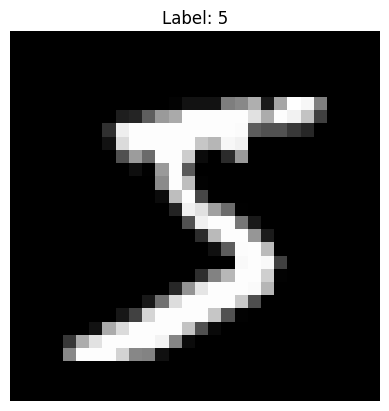

In [8]:
# Remove channel dimension and plot
plt.imshow(img.squeeze(), cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()


In [9]:
def plot_examples(dataset):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flat):
        img, label = dataset[i]
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f"Label: {label}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()


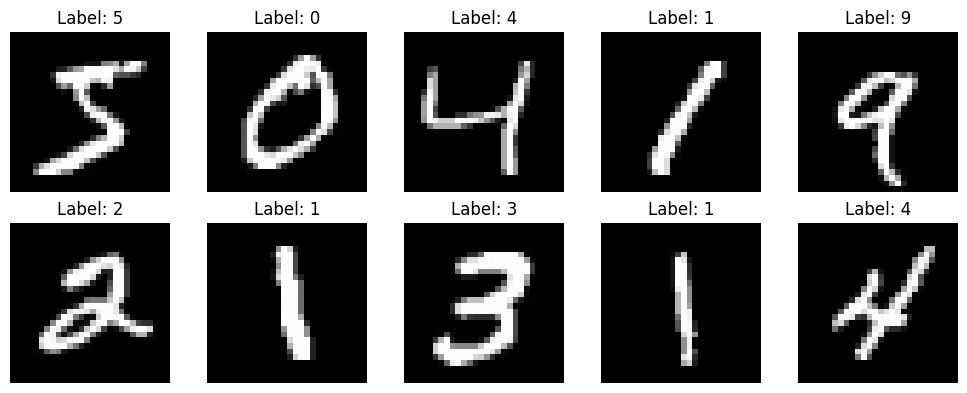

In [10]:
plot_examples(train_dataset)

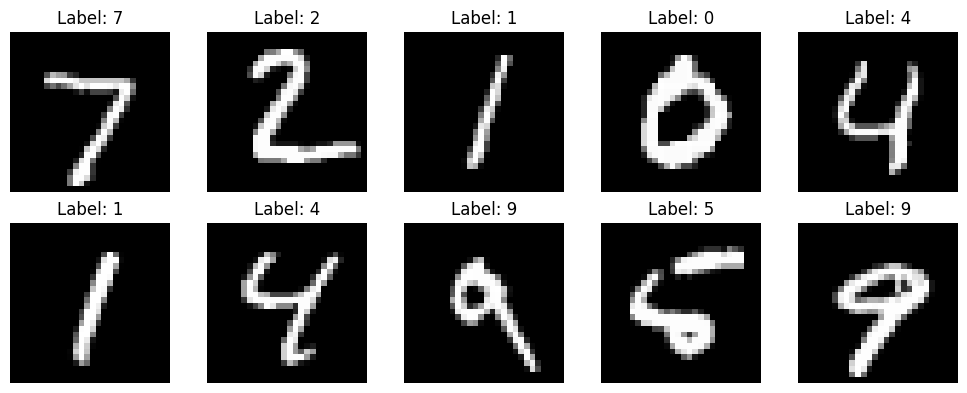

In [11]:
plot_examples(test_dataset)

# Train a simple NN for classification

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')

device: cuda


In [13]:
model = nn.Sequential(
    nn.Flatten(),              # Flattens [1, 28, 28] → [784]
    nn.Linear(784, 128),       # FC layer
    nn.ReLU(),                 # Activation
    nn.Dropout(0.3),           # Dropout with 30% probability
    nn.Linear(128, 10)         # Output layer (10 classes)
)

model = model.to(device)

In [14]:
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=128, out_features=10, bias=True)
)


In [15]:
# expected number of parameters
(784 * 128 + 128) + 128*10 + 10

101770

In [16]:
# Create input and move it to the same device # For example: input shape (1, 28, 28) for MNIST
summary(model, input_size=(1, 28, 28), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
           Dropout-4                  [-1, 128]               0
            Linear-5                   [-1, 10]           1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.39
Estimated Total Size (MB): 0.40
----------------------------------------------------------------


In [17]:
sample_input = torch.rand(1, 1, 28, 28).to(device)
output = model(sample_input)
print(output.shape)  # torch.Size([1, 10])
print(output)

torch.Size([1, 10])
tensor([[-0.2715,  0.2277,  0.0941,  0.1586, -0.1121,  0.2925,  0.0826,  0.1701,
         -0.0721, -0.2017]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [18]:
def get_label(img):
    output = model(img.to(device))
    probs = torch.softmax(output, dim=1)
    label = torch.argmax(probs, dim=1)
    return label.item()

In [19]:
def plot_examples(dataset):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flat):
        img, label = dataset[i]
        get_label(img)
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f"True: {label}, Predicted: {get_label(img)}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Plot some predictions BEFORE training - seem pretty random!

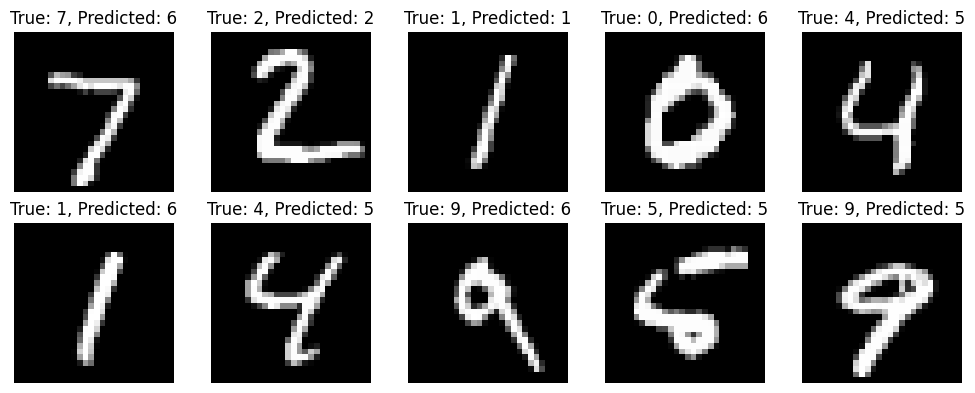

In [20]:
plot_examples(test_dataset)

Calculate the accuracy before training - expect in the order of 10%

This one takes a long time!

In [21]:
correct = 0
total = 0
model.eval()

with torch.no_grad():
    for i in range(len(test_dataset)):
        img, label = test_dataset[i]
        img = img.to(device)

        output = model(img)
        pred = torch.argmax(output, dim=1).item()

        correct += (pred == label)
        total += 1

accuracy = correct / total
print(f'Accuracy: {accuracy * 100:.2f}% in a total of {total} test samples')


Accuracy: 12.13% in a total of 10000 test samples


This is a much faster way

In [22]:
# Prepare DataLoader for test set
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
model.eval()  # Set model to evaluation mode

def get_accuracy():

    correct = 0
    total = 0
    
    with torch.no_grad():  # No gradients needed for evaluation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)             # Get logits
            _, predicted = torch.max(outputs, 1)  # Get predicted class indices; could also use argmax since only need labels for now
            
            total += labels.size(0)             # Number of samples in batch
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    print(f'Accuracy on test set: {accuracy * 100:.2f}%')


In [23]:
get_accuracy()

Accuracy on test set: 12.13%


Now train!

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 20

val_size = 5000
train_size = len(train_dataset) - val_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

training_loss = []
validation_loss = []

for epoch in range(num_epochs):
    # ------------- check on the validation set before pass ------------- # 
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = correct / total

    #------------- train ------------
    
    model.train()
    train_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        

    train_loss /= len(train_loader)

    training_loss.append(train_loss)
    validation_loss.append(val_loss)

    print(f"Epoch {epoch+1}, Loss: {train_loss:.4f} Validation Loss: {val_loss:.4f}, Accuracy: {val_acc * 100:.2f}%")

print("Training complete.")


Epoch 1, Loss: 0.4042 Validation Loss: 2.3039, Accuracy: 12.56%
Epoch 2, Loss: 0.2006 Validation Loss: 0.2097, Accuracy: 93.92%
Epoch 3, Loss: 0.1518 Validation Loss: 0.1453, Accuracy: 95.56%
Epoch 4, Loss: 0.1254 Validation Loss: 0.1165, Accuracy: 96.56%
Epoch 5, Loss: 0.1088 Validation Loss: 0.0991, Accuracy: 96.96%
Epoch 6, Loss: 0.0963 Validation Loss: 0.0938, Accuracy: 97.12%
Epoch 7, Loss: 0.0857 Validation Loss: 0.0848, Accuracy: 97.34%
Epoch 8, Loss: 0.0794 Validation Loss: 0.0840, Accuracy: 97.44%
Epoch 9, Loss: 0.0719 Validation Loss: 0.0802, Accuracy: 97.76%
Epoch 10, Loss: 0.0659 Validation Loss: 0.0778, Accuracy: 97.80%
Epoch 11, Loss: 0.0620 Validation Loss: 0.0798, Accuracy: 97.80%
Epoch 12, Loss: 0.0572 Validation Loss: 0.0754, Accuracy: 97.86%
Epoch 13, Loss: 0.0542 Validation Loss: 0.0762, Accuracy: 97.82%
Epoch 14, Loss: 0.0506 Validation Loss: 0.0769, Accuracy: 97.84%
Epoch 15, Loss: 0.0479 Validation Loss: 0.0791, Accuracy: 97.80%
Epoch 16, Loss: 0.0457 Validation 

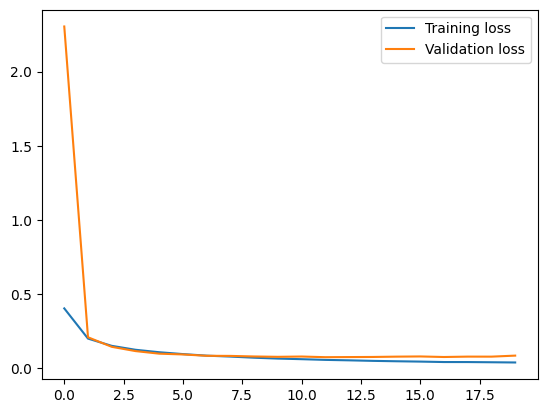

In [25]:
plt.plot(range(num_epochs), training_loss, label='Training loss')
plt.plot(range(num_epochs), validation_loss, label='Validation loss')
plt.legend()

Note, without dropout we have signs of overfitting - the validation loss gets increased for later epochs, while training keeps decreasing. Though final accuracy is not improved (actually worsens slightly, but that could be just noise)

In [26]:
get_accuracy()

Accuracy on test set: 97.15%


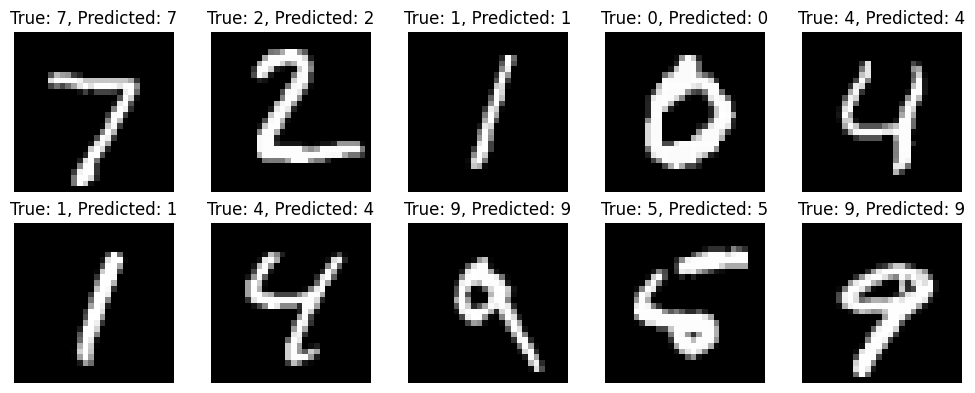

In [27]:
plot_examples(test_dataset)

# Now to the GAN!

In [28]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(100, 256),
            #nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            #nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            #nn.ReLU(),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            #nn.ReLU(),
            #n.Linear(512, 1024),
            #nn.BatchNorm1d(512),
            #nn.LeakyReLU(),
            #nn.ReLU(),
            nn.Linear(1024, 784),
            #nn.Linear(512, 784),
            #nn.Linear(256, 784),
            #nn.Sigmoid(),
            nn.Tanh()
            #nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

generator = Generator().to(device)
print(generator)

Generator(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Linear(in_features=512, out_features=1024, bias=True)
    (6): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=1024, out_features=784, bias=True)
    (9): Tanh()
  )
)


In [29]:
10*128+128 + 128*256+256 + 256*784+784

235920

In [31]:
#summary(generator, input_size=(1, 100), device=str(device))

In [32]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

discriminator = Discriminator().to(device)
print(discriminator)

Discriminator(
  (linear_relu_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=1024, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=512, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=1, bias=True)
    (9): Sigmoid()
  )
)


In [33]:
summary(discriminator, input_size=(1, 28, 28), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1024]         803,840
              ReLU-3                 [-1, 1024]               0
            Linear-4                  [-1, 512]         524,800
              ReLU-5                  [-1, 512]               0
           Dropout-6                  [-1, 512]               0
            Linear-7                  [-1, 128]          65,664
              ReLU-8                  [-1, 128]               0
            Linear-9                    [-1, 1]             129
          Sigmoid-10                    [-1, 1]               0
Total params: 1,394,433
Trainable params: 1,394,433
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 5.32
Estimat

Generate some images from the untrained generator

In [59]:
#sample_input = torch.randn(10, 100).to(device) # sample from uniform latent space - geenerate 10 sampls
sample_input = torch.rand(10, 100).to(device) # sample from uniform latent space - geenerate 10 sampls
output = (1+generator(sample_input).view(-1, 1, 28, 28))/2

In [60]:
def plot_examples(dataset):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flat):
        img = dataset[i]
        ax.imshow(img.squeeze(), cmap='gray')
        #ax.set_title(f"True: {label}, Predicted: {get_label(img)}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

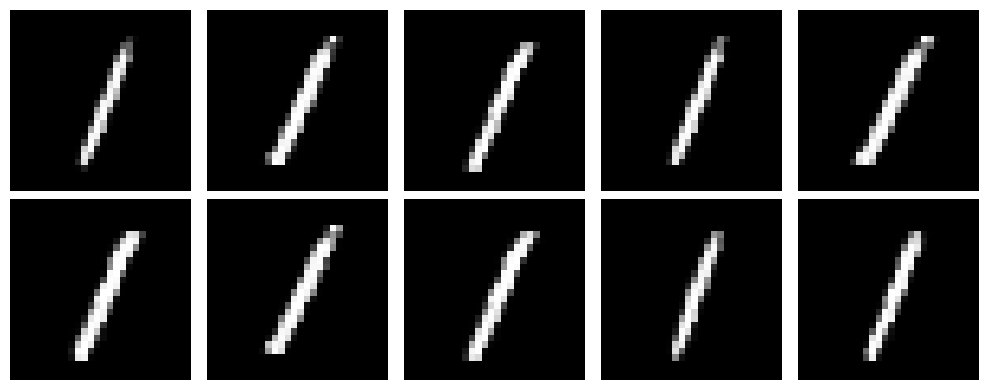

In [61]:
with torch.no_grad():
    generated_images = output.cpu()
plot_examples(generated_images)

Generates noise - as expected!

Check the vanishing gradient!

In [428]:
# check the reason for vanishing gradient
si = torch.rand(1, 100).to(device)
out = generator(si).view(-1, 1, 28, 28)
#D = discriminator(out)
#D.backward()
#l = torch.log(D)
#l.backward()
#m = out.mean()
#m.backward()
p = out[0][0][10][10]
p.backward()
for name, param in generator.named_parameters():
    if param.grad is not None:
        print(name, param.grad.abs().mean().item())

linear_relu_stack.0.weight 0.00011637218995019794
linear_relu_stack.0.bias 0.00023347814567387104
linear_relu_stack.2.weight 5.6149256124626845e-05
linear_relu_stack.2.bias 0.0003986024239566177
linear_relu_stack.4.weight 6.11127179581672e-05
linear_relu_stack.4.bias 0.0009610687266103923
linear_relu_stack.6.weight 4.9163376388605684e-05
linear_relu_stack.6.bias 0.0019924708176404238
linear_relu_stack.8.weight 4.745498245029012e-06
linear_relu_stack.8.bias 0.0003188295231666416


In [430]:
si = torch.rand(1, 100).to(device)
out = generator(si).view(-1, 1, 28, 28)
D = discriminator(out)
D.backward()
for name, param in discriminator.named_parameters():
    if param.grad is not None:
        print(name, param.grad.abs().mean().item())

linear_relu_stack.1.weight 0.0031196181662380695
linear_relu_stack.1.bias 0.006235840264707804
linear_relu_stack.4.weight 0.02923920750617981
linear_relu_stack.4.bias 0.24640776216983795


Now give these images to the discriminator

In [37]:
D = discriminator(output)

In [38]:
D

tensor([[0.4861],
        [0.4856],
        [0.4839],
        [0.4774],
        [0.4863],
        [0.4824],
        [0.4823],
        [0.4822],
        [0.4825],
        [0.4839]], device='cuda:0', grad_fn=<SigmoidBackward0>)

Try to give real images too

In [39]:
train_loader_small = DataLoader(train_subset, batch_size=10)
for images, labels in train_loader_small:
    images = images.to(device)
    outputs = discriminator(images)
    break  # Just first batch


In [40]:
outputs

tensor([[0.4860],
        [0.4877],
        [0.4865],
        [0.4842],
        [0.4781],
        [0.4815],
        [0.4826],
        [0.4850],
        [0.4827],
        [0.4809]], device='cuda:0', grad_fn=<SigmoidBackward0>)

Ok, for both the real data and noise generator gives 1/2 probability - as expected, becuase its not trained

In order to train the discriminator, we want to minimize the following loss with respect to the discriminator parameters:

$$
L = -\sum_{i=1}^{N_r} \log D(x_i) - \sum_{j=1}^{N_g} \log \left( 1-D(G(z_j)) \right)
$$
The first sum runs over $N_r$ real data samples $x_i$ while the second sum runs over $N_g$ random samples $z_j$ from the latent space.
This result can be obtained from the maximum likelihood principle, i.e. finding the model parameters which maximize the probability of the observed dataset.
The probability that a given sample $x_i$ is real is given by $D(x_i)$. The probability that a given sample $G(z_j)$ is real is given by $D(G(z_j))$, and hence the probability for it to be generated is $1-D(G(z_j))$. Thus, for a set of $N_r$ real and $N_g$ generated samples, the overall probability is
$$
P = \prod_{i=1}^{N_r} D(x_i) \prod_{j=1}^{N_g}  1-D(G(z_j))
$$
The negative log-likelihood is then 
$$
L = -\log P =\sum_i \log D(x_i) - \sum_j \log \left( 1-D(G(z_j))\right)
$$

In order to train the generator, we can _maximize_ the above loss with respect to generator parameters. This follows from the "zero-sum game" or "min-max" idea, i.e. the generator and discriminator compete by maximizing and minimizing the same loss function. Since only the 2nd term depends on G, we maximize the 2nd term only, or minimize the following term:
$$
L = \sum_j \log \left( 1-D(G(z_j)) \right)
$$

Alternatively, we can also start from the maximum likelihood principle, this time for the generator. The goal of the generator is to generate realistic images, so that the discriminator classifies them as real. Thus we want to maximize
$$
P = \prod_{j=1}^{N_g} D(G(z_j)
$$
or in terms of the negative log-likelihood:
$$
L = - \sum_j \log D(G(z_j)
$$



In [41]:
batch_size = 64
#batch_size = 10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

We also need a dataset for latent space (in order to generate images)

In [62]:
class LatentSpaceDataset(Dataset):
    def __init__(self, n_samples, dim):
        self.n_samples = n_samples
        self.dim = dim

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        #x = torch.randn(self.dim)
        x = torch.rand(self.dim)
        return x

In [43]:
latent_dataset = LatentSpaceDataset(60000, 100) # let's keep the number of random samples the same as the number of real images
latent_loader = DataLoader(latent_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [63]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1 or classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

# Apply to both models
generator.apply(weights_init)
discriminator.apply(weights_init)


Discriminator(
  (linear_relu_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=1024, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=512, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

In [45]:
for name, param in generator.named_parameters():
    if "weight" in name:
        print(f"{name}: {param.view(-1)[:5]}")
        break  # only first layer


linear_relu_stack.0.weight: tensor([-0.0151,  0.0316, -0.0039, -0.0195,  0.0032], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [46]:
for name, param in discriminator.named_parameters():
    if "weight" in name:
        print(f"{name}: {param.view(-1)[:5]}")
        break  # only first layer


linear_relu_stack.1.weight: tensor([ 0.0406,  0.0244, -0.0137,  0.0223, -0.0100], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [47]:
# Create a BCEWithLogitsLoss criterion
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCELoss()

real_labels = torch.ones(batch_size, 1, device=device)   # labels = 1 for real
fake_labels = torch.zeros(batch_size, 1, device=device)  # labels = 0 for fake

In [48]:
batch_size

64

## Option 1 - BCE Loss (no Sigmoid as a last layer of D, outputs logits)

In [64]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [65]:
for images, _ in train_loader:

    images = images.to(device)

    # Discriminator loss on real data
    logit_real = discriminator(images)
    loss_real = criterion(logit_real, real_labels)

    print(loss_real)

    #latent_vectors = torch.randn(batch_size, 100, device=device)
    latent_vectors = torch.rand(batch_size, 100, device=device)
    G = (1+generator(latent_vectors))/2
    prob_fake = discriminator(G)
    loss_fake = criterion(prob_fake, fake_labels)

    print(loss_fake)

    print("Expected initial D loss:", loss_fake+loss_real)

    print(criterion(prob_fake, real_labels))

    break

tensor(0.6794, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Expected initial D loss: tensor(1.3925, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6736, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


In [51]:
import numpy as np
-np.log(0.5) # initially D cant distinguish between real and fake and outputs p=0.5 for all

np.float64(0.6931471805599453)

In [52]:
-np.log(1-0.5) # initially D cant distinguish between real and fake and outputs p=0.5 for all

np.float64(0.6931471805599453)

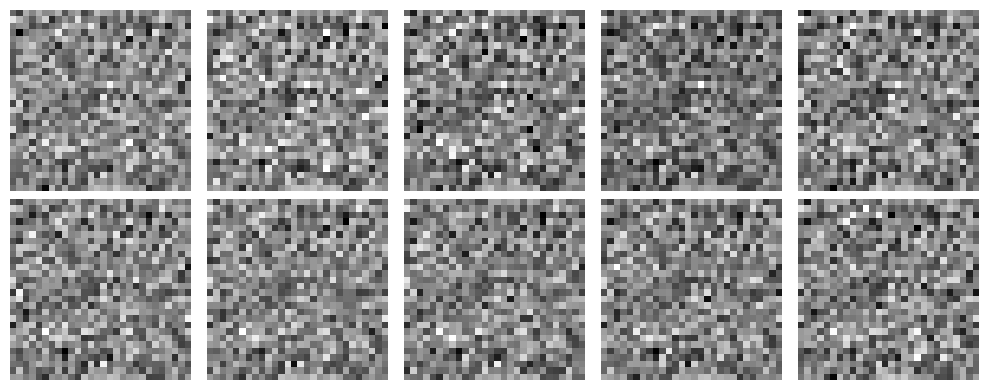

Epoch 0, batch 0 of 937. D-loss: 1.3900339603424072, G-loss: 0.7117923498153687
Epoch 1 Finished. Average discriminator Loss: 0.346008 (0.155170, 0.190837), Average generator Loss: 3.395233701345518. Updated Discriminator 937 times. D threshold 0
Epoch 2 Finished. Average discriminator Loss: 0.423143 (0.258386, 0.164757), Average generator Loss: 2.9235326111507516. Updated Discriminator 937 times. D threshold 0
Epoch 3 Finished. Average discriminator Loss: 0.455429 (0.279294, 0.176135), Average generator Loss: 2.5381217250956287. Updated Discriminator 937 times. D threshold 0
Epoch 4 Finished. Average discriminator Loss: 0.490757 (0.302948, 0.187809), Average generator Loss: 2.294078429455182. Updated Discriminator 937 times. D threshold 0
Epoch 5 Finished. Average discriminator Loss: 0.503748 (0.309529, 0.194219), Average generator Loss: 2.223389282170584. Updated Discriminator 937 times. D threshold 0


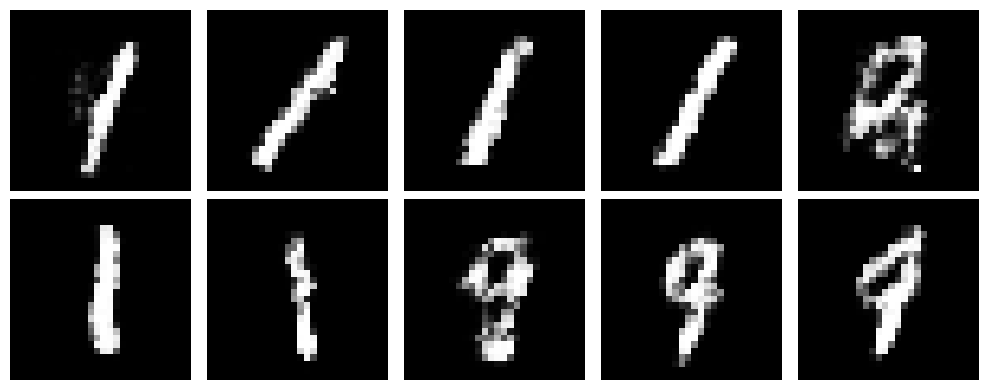

Epoch 6 Finished. Average discriminator Loss: 0.525866 (0.319821, 0.206045), Average generator Loss: 2.1840390645070924. Updated Discriminator 937 times. D threshold 0
Epoch 7 Finished. Average discriminator Loss: 0.539535 (0.327089, 0.212445), Average generator Loss: 2.129060322854155. Updated Discriminator 937 times. D threshold 0
Epoch 8 Finished. Average discriminator Loss: 0.534982 (0.324533, 0.210449), Average generator Loss: 2.141372806361798. Updated Discriminator 937 times. D threshold 0
Epoch 9 Finished. Average discriminator Loss: 0.543097 (0.330083, 0.213014), Average generator Loss: 2.1229166134698922. Updated Discriminator 937 times. D threshold 0
Epoch 10 Finished. Average discriminator Loss: 0.543263 (0.331508, 0.211755), Average generator Loss: 2.09401577844691. Updated Discriminator 937 times. D threshold 0


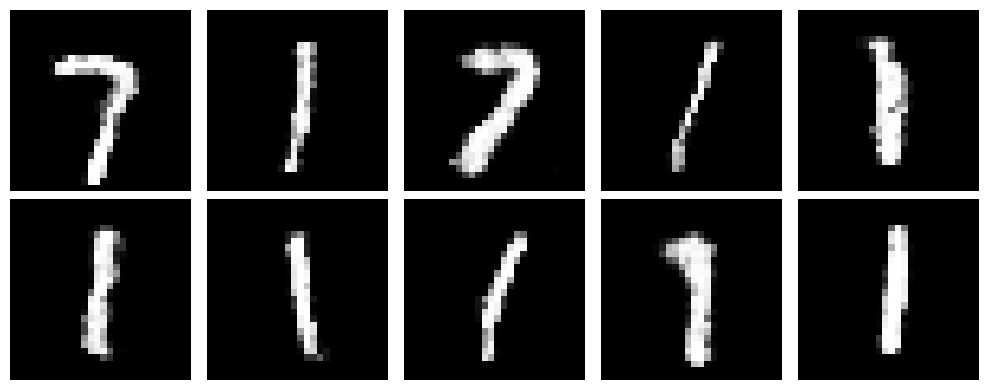

Epoch 11 Finished. Average discriminator Loss: 0.533789 (0.330016, 0.203772), Average generator Loss: 2.0984394178828154. Updated Discriminator 937 times. D threshold 0
Epoch 12 Finished. Average discriminator Loss: 0.522567 (0.324474, 0.198092), Average generator Loss: 2.1275774866437964. Updated Discriminator 937 times. D threshold 0
Epoch 13 Finished. Average discriminator Loss: 0.518157 (0.322027, 0.196130), Average generator Loss: 2.1392522331490205. Updated Discriminator 937 times. D threshold 0
Epoch 14 Finished. Average discriminator Loss: 0.513257 (0.320028, 0.193230), Average generator Loss: 2.1590892918718025. Updated Discriminator 937 times. D threshold 0
Epoch 15 Finished. Average discriminator Loss: 0.506016 (0.315933, 0.190082), Average generator Loss: 2.1774554984164975. Updated Discriminator 937 times. D threshold 0


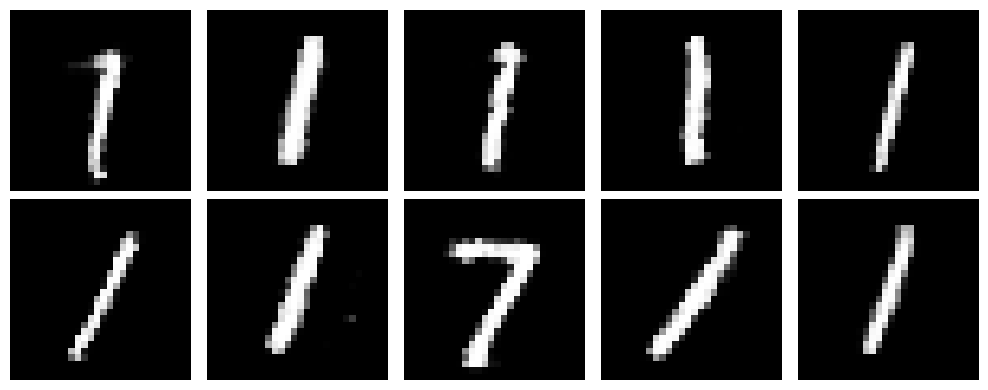

Epoch 16 Finished. Average discriminator Loss: 0.498963 (0.313083, 0.185880), Average generator Loss: 2.193397340296172. Updated Discriminator 937 times. D threshold 0
Epoch 17 Finished. Average discriminator Loss: 0.493082 (0.309435, 0.183647), Average generator Loss: 2.202892551427208. Updated Discriminator 937 times. D threshold 0
Epoch 18 Finished. Average discriminator Loss: 0.487599 (0.306044, 0.181555), Average generator Loss: 2.249303693577981. Updated Discriminator 937 times. D threshold 0
Epoch 19 Finished. Average discriminator Loss: 0.481308 (0.304145, 0.177164), Average generator Loss: 2.2590050182067722. Updated Discriminator 937 times. D threshold 0
Epoch 20 Finished. Average discriminator Loss: 0.475179 (0.301437, 0.173742), Average generator Loss: 2.269821941152835. Updated Discriminator 937 times. D threshold 0


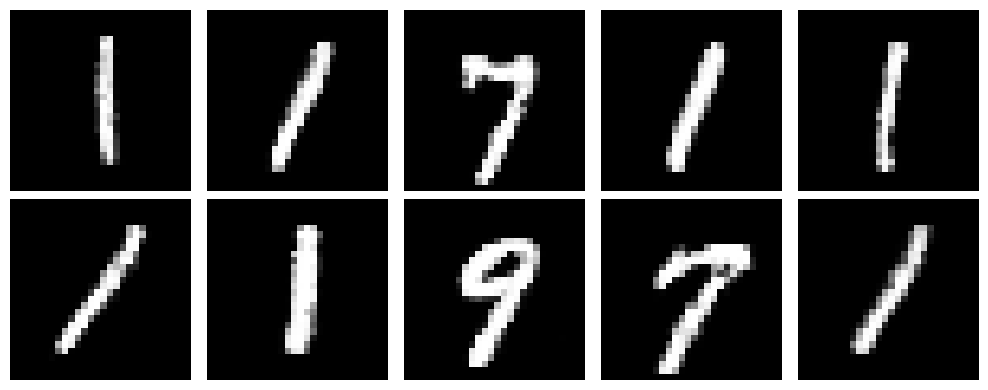

Epoch 21 Finished. Average discriminator Loss: 0.464731 (0.295782, 0.168949), Average generator Loss: 2.298098815288971. Updated Discriminator 937 times. D threshold 0
Epoch 22 Finished. Average discriminator Loss: 0.462791 (0.295543, 0.167248), Average generator Loss: 2.3223743723703425. Updated Discriminator 937 times. D threshold 0
Epoch 23 Finished. Average discriminator Loss: 0.461384 (0.293753, 0.167631), Average generator Loss: 2.3408794081198367. Updated Discriminator 937 times. D threshold 0
Epoch 24 Finished. Average discriminator Loss: 0.452612 (0.288799, 0.163813), Average generator Loss: 2.3632304621353475. Updated Discriminator 937 times. D threshold 0
Epoch 25 Finished. Average discriminator Loss: 0.450060 (0.287238, 0.162822), Average generator Loss: 2.38556615520058. Updated Discriminator 937 times. D threshold 0


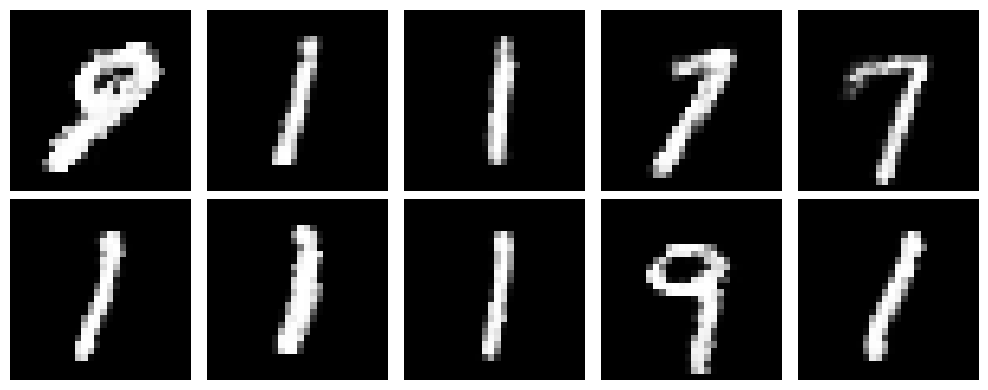

Epoch 26 Finished. Average discriminator Loss: 0.445527 (0.285616, 0.159911), Average generator Loss: 2.4041062449696478. Updated Discriminator 937 times. D threshold 0
Epoch 27 Finished. Average discriminator Loss: 0.443090 (0.283659, 0.159430), Average generator Loss: 2.4262427633574575. Updated Discriminator 937 times. D threshold 0
Epoch 28 Finished. Average discriminator Loss: 0.437377 (0.280460, 0.156918), Average generator Loss: 2.4479314428510635. Updated Discriminator 937 times. D threshold 0
Epoch 29 Finished. Average discriminator Loss: 0.430988 (0.276824, 0.154164), Average generator Loss: 2.4751147319311264. Updated Discriminator 937 times. D threshold 0
Epoch 30 Finished. Average discriminator Loss: 0.425671 (0.273590, 0.152081), Average generator Loss: 2.5075952309554514. Updated Discriminator 937 times. D threshold 0


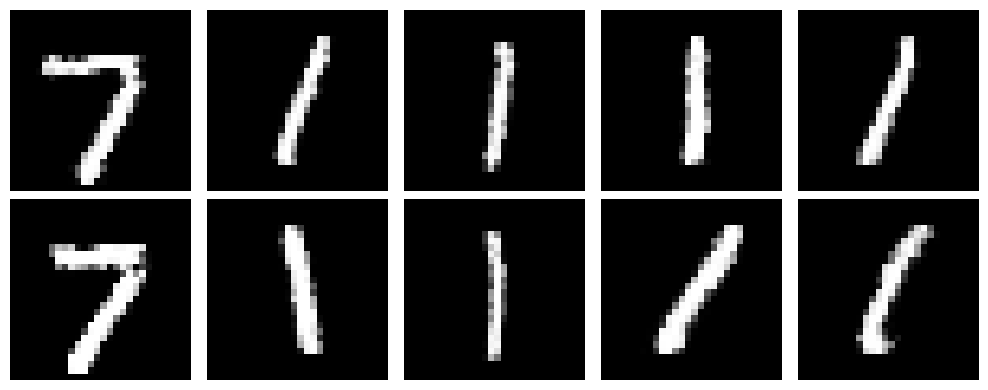

Epoch 31 Finished. Average discriminator Loss: 0.416952 (0.268799, 0.148153), Average generator Loss: 2.535794697550852. Updated Discriminator 937 times. D threshold 0
Epoch 32 Finished. Average discriminator Loss: 0.413630 (0.266944, 0.146687), Average generator Loss: 2.5567661095072647. Updated Discriminator 937 times. D threshold 0
Epoch 33 Finished. Average discriminator Loss: 0.403227 (0.261337, 0.141890), Average generator Loss: 2.6037748875205775. Updated Discriminator 937 times. D threshold 0
Epoch 34 Finished. Average discriminator Loss: 0.401094 (0.260458, 0.140637), Average generator Loss: 2.614050304368059. Updated Discriminator 937 times. D threshold 0
Epoch 35 Finished. Average discriminator Loss: 0.397609 (0.257602, 0.140007), Average generator Loss: 2.639711737251078. Updated Discriminator 937 times. D threshold 0


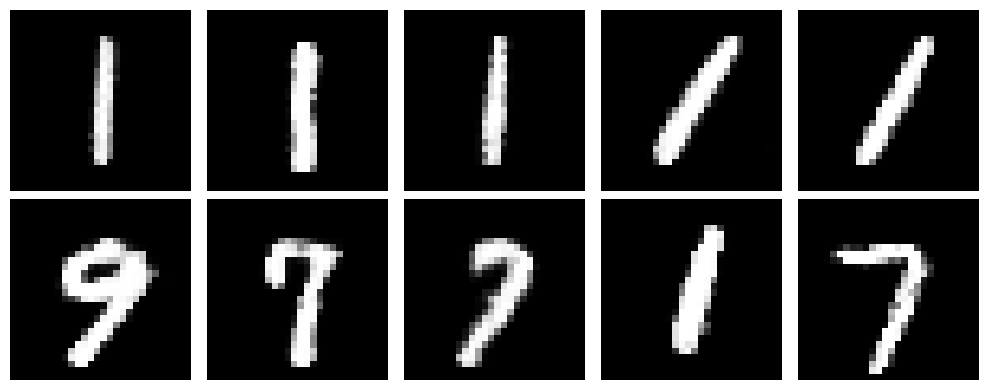

Epoch 36 Finished. Average discriminator Loss: 0.388739 (0.252923, 0.135816), Average generator Loss: 2.6976800288054834. Updated Discriminator 937 times. D threshold 0
Epoch 37 Finished. Average discriminator Loss: 0.385229 (0.249949, 0.135280), Average generator Loss: 2.7256891615490013. Updated Discriminator 937 times. D threshold 0
Epoch 38 Finished. Average discriminator Loss: 0.384782 (0.249635, 0.135146), Average generator Loss: 2.70291431685522. Updated Discriminator 937 times. D threshold 0
Epoch 39 Finished. Average discriminator Loss: 0.373299 (0.244572, 0.128726), Average generator Loss: 2.7553874507403298. Updated Discriminator 937 times. D threshold 0
Epoch 40 Finished. Average discriminator Loss: 0.369110 (0.241744, 0.127366), Average generator Loss: 2.763886493705253. Updated Discriminator 937 times. D threshold 0


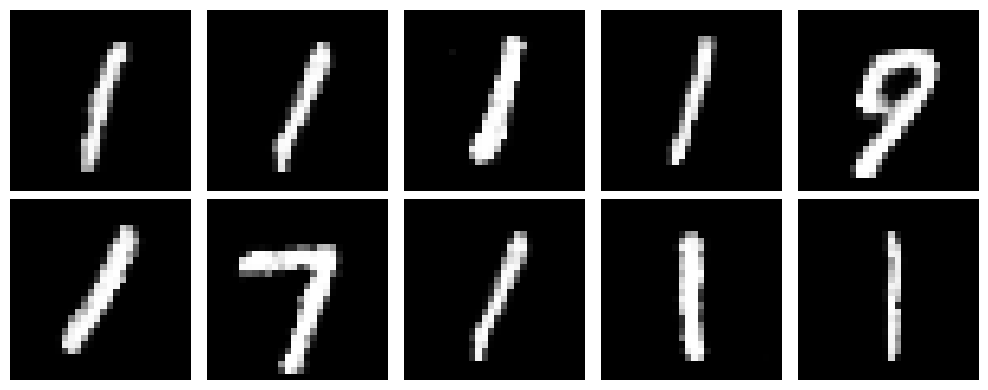

Epoch 41 Finished. Average discriminator Loss: 0.364822 (0.238846, 0.125976), Average generator Loss: 2.8205525768223034. Updated Discriminator 937 times. D threshold 0
Epoch 42 Finished. Average discriminator Loss: 0.360060 (0.236678, 0.123382), Average generator Loss: 2.813000035514954. Updated Discriminator 937 times. D threshold 0
Epoch 43 Finished. Average discriminator Loss: 0.348938 (0.229763, 0.119176), Average generator Loss: 2.8834678320136624. Updated Discriminator 937 times. D threshold 0
Epoch 44 Finished. Average discriminator Loss: 0.347168 (0.227795, 0.119374), Average generator Loss: 2.9248045941172696. Updated Discriminator 937 times. D threshold 0
Epoch 45 Finished. Average discriminator Loss: 0.344147 (0.226851, 0.117296), Average generator Loss: 2.9306528560634355. Updated Discriminator 937 times. D threshold 0


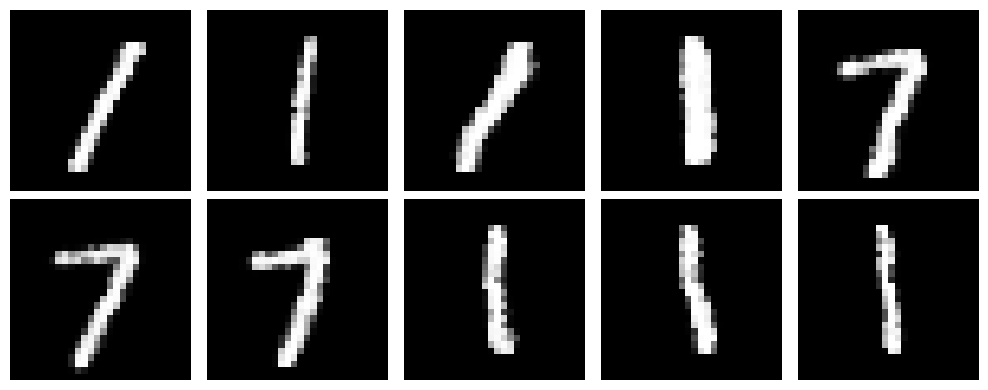

Epoch 46 Finished. Average discriminator Loss: 0.336872 (0.221815, 0.115057), Average generator Loss: 2.9763030275591156. Updated Discriminator 937 times. D threshold 0
Epoch 47 Finished. Average discriminator Loss: 0.336207 (0.221382, 0.114825), Average generator Loss: 2.956946874250088. Updated Discriminator 937 times. D threshold 0
Epoch 48 Finished. Average discriminator Loss: 0.331360 (0.218098, 0.113261), Average generator Loss: 2.9969826528331387. Updated Discriminator 937 times. D threshold 0
Epoch 49 Finished. Average discriminator Loss: 0.322648 (0.213856, 0.108792), Average generator Loss: 3.0578378768460857. Updated Discriminator 937 times. D threshold 0
Epoch 50 Finished. Average discriminator Loss: 0.328057 (0.216674, 0.111383), Average generator Loss: 3.0212755340649453. Updated Discriminator 937 times. D threshold 0
Training complete.


In [66]:
num_epochs = 50
# we update the discriminator more rarely, otherwise generator struggles to train
discriminator_fraction_update = 200
discriminator_epoch_update = 5 # update ever 10th epoch
allow_discriminator_update = True

batch_print = 200
batch = 0

D_loss = []
G_loss = []
n_D_updates_per_epoch = 1000
for epoch in range(num_epochs):
 
    discriminator_epoch_loss = 0.0
    loss_real_tot = 0.0
    loss_fake_tot = 0.0
    generator_epoch_loss = 0.0

    if epoch % discriminator_epoch_update == 0:
        allow_discriminator_update = True
    else:
        allow_discriminator_update = False
    
    # note, no need for labels as we train in an unsupervised fashion!
    i = 0
    batch = 0
    for images, _ in train_loader:    
        
        images = images.to(device)
        #latent_vectors = latent_vectors.to(device)
        #latent_vectors = torch.randn(batch_size, 100, device=device) 
        latent_vectors = torch.rand(batch_size, 100, device=device) 

        ########################################################################
        # Step 1. Train the discriminator, keep the generator fixed.
        ########################################################################
        discriminator.train()
        generator.eval()
        discriminator_optimizer.zero_grad()

        with torch.no_grad():
            G = (1+generator(latent_vectors))/2

        if epoch % 5 == 0 and batch == 0:
            plot_examples(G.view(-1, 1, 28, 28).cpu())
        
        # Discriminator loss on real data
        logit_real = discriminator(images)
        #print(real_labels.size())
        #print(logit_real.size())
        loss_real = criterion(logit_real, real_labels)
        # Discriminator loss on fake data
        loss_fake = criterion(discriminator(G), fake_labels)
        # Total discriminator loss
        loss_D = loss_real + loss_fake

        loss_D.backward()
        #if i < n_D_updates_per_epoch and loss_D > 0.5 and allow_discriminator_update:
        #if i < n_D_updates_per_epoch and allow_discriminator_update:
        #if (i < n_D_updates_per_epoch and allow_discriminator_upda2e) or (10<epoch<=15):
        #if (loss_D >0.7 and allow_discriminator_update) or epoch < 2: # train D more intensely in the first epochs and later epochs
        #if (loss_D >0.7 and allow_discriminator_update): # train D more intensely in the first epochs and later epochs
        thr = 0
        if loss_D > thr: 
            discriminator_optimizer.step()
            i +=1
            #print("updated D")
        discriminator_epoch_loss += loss_D.item()

        loss_real_tot += loss_real
        loss_fake_tot += loss_fake

        ########################################################################
        # Step 2. Train the generator, keep the discriminator fixed.
        ########################################################################
        discriminator.eval()
        generator.train()      
        generator_optimizer.zero_grad()
        latent_vectors = torch.rand(batch_size, 100, device=device) 
        G = (1+generator(latent_vectors))/2
        
        # Generator tries to fool discriminator, so uses real labels for fake outputs
        loss_G = criterion(discriminator(G), real_labels)
        loss_G.backward()

        generator_optimizer.step()
        generator_epoch_loss += loss_G.item()

        if batch  == 0 and epoch==0:
            print(f'Epoch {epoch}, batch {batch} of {len(train_loader)}. D-loss: {loss_D}, G-loss: {loss_G}')
        batch += 1

    discriminator_epoch_loss /= len(train_loader)
    generator_epoch_loss /= len(train_loader)
    loss_real_tot /= len(train_loader)
    loss_fake_tot /= len(train_loader)

    # we can disable the discrimiinator update for the next epoch, if the generator loss gets too large
    #if generator_epoch_loss > 50:
    #    allow_discriminator_update = False
    #elif generator_epoch_loss<=50 and epoch > 5:
    #    allow_discriminator_update = True

    D_loss.append(discriminator_epoch_loss)
    G_loss.append(generator_epoch_loss)

    print(f"Epoch {epoch+1} Finished. Average discriminator Loss: {discriminator_epoch_loss:4f} ({loss_real_tot:4f}, {loss_fake_tot:4f}), Average generator Loss: {generator_epoch_loss}. Updated Discriminator {i} times. D threshold {thr}")

print("Training complete.")

## Option 2 - Manually calculated loss (Sigmoid as a last layer of D)

In [70]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.003)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)

In [73]:
num_epochs = 10000
# we update the discriminator more rarely, otherwise generator struggles to train
discriminator_fraction_update = 200
discriminator_epoch_update = 2 # update ever 10th epoch
allow_discriminator_update = False


D_loss = []
G_loss = []

for epoch in range(num_epochs):
 
    discriminator_epoch_loss = 0.0
    generator_epoch_loss = 0.0

    if epoch % discriminator_epoch_update == 0:
        allow_discriminator_update = True
    else:
        allow_discriminator_update = False

    i = 0
    # note, no need for labels as we train in an unsupervised fashion!
    for images, _ in train_loader:

        images = images.to(device)
        #latent_vectors = latent_vectors.to(device)
        latent_vectors = torch.randn(batch_size, 100, device=device) 

        ########################################################################
        # Step 1. Train the discriminator, keep the generator fixed.
        ########################################################################
        discriminator.train()
        generator.eval()
        discriminator_optimizer.zero_grad()
        generator_optimizer.zero_grad() # dont need this actually

        # calculate the first sum (see formula above)
        D = discriminator(images)
        loss1 = - torch.log(D).sum() # this is the first sum
        #print(f"Step1: loss1={loss1}")

        # calculate the second sum (see formula above)
        with torch.no_grad():  # no gradients tracked here
            G = (1+generator(latent_vectors))/2          
        loss2 = - torch.log(1-discriminator(G.detach())).sum()
        #print(f"In Step1: loss2={loss2}")

        # calculate the sum of two terms, and perfomr the optimization step
        loss = loss1 + loss2
        loss.backward()
        #for name, param in discriminator.named_parameters():
        #    if param.grad is not None:
        #        print(name, param.grad.abs().mean().item())
        #if i % discriminator_fraction_update == 0 and allow_discriminator_update:
        #if allow_discriminator_update and loss>10/(epoch+1):
        #    discriminator_optimizer.step()
        if allow_discriminator_update and loss>20:
            discriminator_optimizer.step()
            i += 1
            
        discriminator_epoch_loss += loss.item()


        ########################################################################
        # Step 2. Train the generator, keep the discriminator fixed.
        ########################################################################
        discriminator.eval()
        generator.train()      
        discriminator_optimizer.zero_grad() # dont need this actually
        generator_optimizer.zero_grad()

        # here we only need the second term because the first one doesn't involve the generator at all!
        # calculate the second sum (see formula above)
        # Note, the lack of "-" in front of the sum - we want to minimize here, while in the formula we maximize wrt to the generator (i.e. optimize in a different direction)
        G = (1+generator(latent_vectors))/2
        #loss = torch.log(1-discriminator(G)).sum()
        loss = -torch.log(discriminator(G)).sum() # this is better numerically - ?? for small x we have log(1+x) ~ x, thus if D(G) is close to zero (i.e. D is very good in guessing) we can simplify the formula
        #print(f"In Step2: loss2={loss}")
        loss.backward()
        #for name, param in generator.named_parameters():
        #    if param.grad is not None:
        #        print(name, param.grad.abs().mean().item())
        generator_optimizer.step()
        generator_epoch_loss += loss.item()

        #if i==10:
        #    break
        #i+=1

    discriminator_epoch_loss /= len(train_loader)
    generator_epoch_loss /= len(train_loader)

    # we can disable the discrimiinator update for the next epoch, if the generator loss gets too large
    #if generator_epoch_loss > 50:
    #    allow_discriminator_update = False
    #elif generator_epoch_loss<=50 and epoch > 5:
    #    allow_discriminator_update = True

    D_loss.append(discriminator_epoch_loss)
    G_loss.append(generator_epoch_loss)

    print(f"Epoch {epoch+1}, Discriminator Loss: {discriminator_epoch_loss}, Generator Loss: {generator_epoch_loss}. Updated D {i} times")

print("Training complete.")

Epoch 1, Discriminator Loss: 21.88886922044459, Generator Loss: 195.18581912306354. Updated D 539 times
Epoch 2, Discriminator Loss: 210.8040631435724, Generator Loss: 16.400429458602897. Updated D 0 times
Epoch 3, Discriminator Loss: 23.765816202031385, Generator Loss: 179.37322867209272. Updated D 531 times
Epoch 4, Discriminator Loss: 206.74740227971031, Generator Loss: 14.911039420609287. Updated D 0 times
Epoch 5, Discriminator Loss: 17.870773225354792, Generator Loss: 179.33499231562416. Updated D 171 times
Epoch 6, Discriminator Loss: 197.07514250927318, Generator Loss: 17.240842938295934. Updated D 0 times
Epoch 7, Discriminator Loss: 22.375000801005, Generator Loss: 202.93834719917436. Updated D 486 times
Epoch 8, Discriminator Loss: 260.0291250975944, Generator Loss: 8.440478352815898. Updated D 0 times
Epoch 9, Discriminator Loss: 20.955487923535618, Generator Loss: 209.6076238758409. Updated D 321 times
Epoch 10, Discriminator Loss: 271.51735956971646, Generator Loss: 12.09

KeyboardInterrupt: 

## Tests

In [54]:
discriminator.eval()
generator.eval()

Generator(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Linear(in_features=512, out_features=1024, bias=True)
    (6): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=1024, out_features=784, bias=True)
    (9): Tanh()
  )
)

In [55]:
train_loader_small = DataLoader(train_dataset, batch_size=10)
for images, labels in train_loader_small:
    images = images.to(device)
    #D = torch.sigmoid(discriminator(images))
    D = discriminator(images)
    break  # Just first batch
D

tensor([[1.0000],
        [1.0000],
        [1.0000],
        [0.1353],
        [1.0000],
        [1.0000],
        [0.2218],
        [1.0000],
        [0.2168],
        [1.0000]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [56]:
latent_vectors = torch.randn(10, 100, device=device) 
G = (1+generator(latent_vectors).view(-1, 1, 28, 28))/2

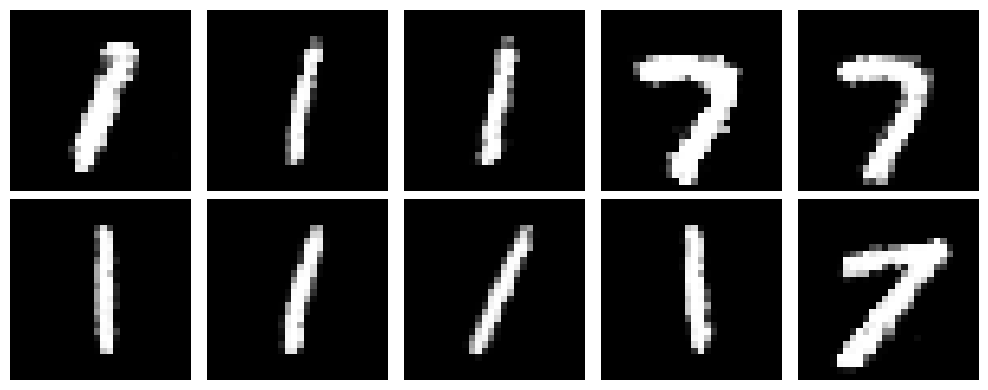

In [57]:
with torch.no_grad():
    generated_images = G.cpu()
plot_examples(generated_images)

In [260]:
#generated_images[0]

In [58]:
torch.sigmoid(discriminator(G))

tensor([[0.5150],
        [0.5061],
        [0.5213],
        [0.5045],
        [0.5085],
        [0.5253],
        [0.5144],
        [0.5070],
        [0.5334],
        [0.5001]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [600]:
-2*np.log(0.5), -np.log(0.5)

(np.float64(1.3862943611198906), np.float64(0.6931471805599453))